### Learning Objectives
The goal of this notebook is to see and practice:
- Creating a data set by merging tables
- Select and engineer features of the data set
  - Transform the values of the data
- Visualize the data set
- See and practice data science research tools and practices

### 1 Practical Data Science Research
Can we find good online learning strategies?

Define:
- "strategy", what is a strategy for learning and how would you observe it?
- What can a strategy look like, what are the features that define it?
- What are the strategies we observe in the data given the features we postulate?

**Note:** The features are important

In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


**Note:** what do we do if it exists and there is data
  in it what are the risks?
- Risk reproduction or recomputing
  - Always delete output folder and make the output and input folders parameters
  - Never delete output folder
    

In [2]:
# Path to the data
DATA_FOLDER = '../data'
# Set plotting style
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# Path to the output we create
OUT_PATH = '../output'
# If path does not exist make it
if not os.path.exists(OUT_PATH):
    # Create folder
    os.mkdir(OUT_PATH)
    

### 2 Create a data set
Why do we need to create a data set?
- The data is rarely structured so each data file contains all the information to answer your research questions.
- Information and insights are often gained by linking data
- The data stored often does not describe the features believed to be useful to answer the research question
 - Which features to select
 - Which new features to create
 

### 3 Does clicking on resources correlate with final result performance for a module?
That is, is a good strategy for learning to click on course resources.

By looking at the schema we see which tables are needed and which columns can be used to merge them into one data set.
The information is spread over multiple tables: `studentVle.csv` and `studentInfo.csv` 

What are other features we can use?

In [3]:
# Load tables
print('studentVle:')
student_vle_path = os.path.join(DATA_FOLDER, 'studentVle.csv')
student_vle = pd.read_csv(student_vle_path)
print(student_vle.info())

print('studentInfo')
student_info_path = os.path.join(DATA_FOLDER, 'studentInfo.csv')
student_info = pd.read_csv(student_info_path)
print(student_info.info())


studentVle:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
code_module          object
code_presentation    object
id_student           int64
id_site              int64
date                 int64
sum_click            int64
dtypes: int64(4), object(2)
memory usage: 487.8+ MB
None
studentInfo
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
code_module             32593 non-null object
code_presentation       32593 non-null object
id_student              32593 non-null int64
gender                  32593 non-null object
region                  32593 non-null object
highest_education       32593 non-null object
imd_band                31482 non-null object
age_band                32593 non-null object
num_of_prev_attempts    32593 non-null int64
studied_credits         32593 non-null int64
disability              32593 non-null object
final_result            32593

Filter on a module code


In [4]:
# Pick one code_module
MODULE_CODE = 'AAA'
student_vle = student_vle.loc[student_vle['code_module'] == MODULE_CODE]
print('student_vle shape: {}'.format(student_vle.shape))
student_info = student_info.loc[student_info['code_module'] == MODULE_CODE]
print('student_info shape: {}'.format(student_info.shape))


student_vle shape: (350298, 6)
student_info shape: (748, 12)


Merge the tables
- Identify the columns to merge the tables on by looking at the schema

**Note:** Keep the tables slim by only selecting the columns we need for the data set creation


In [5]:
# Merge student info and assessment on the student id, module and presentation code. 
student_info_and_vle = pd.merge(student_info, student_vle,
                                on=['code_module', 'id_student', 'code_presentation'],
                                how='inner')
# Get the columns we need (You can get all as well)
student_info_and_vle = student_info_and_vle[
    ['id_student', 'final_result', 'code_module', 'code_presentation', 'sum_click', 'id_site']
]
student_info_and_vle.drop_duplicates(inplace=True)
print(student_info_and_vle.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 128277 entries, 0 to 350294
Data columns (total 6 columns):
id_student           128277 non-null int64
final_result         128277 non-null object
code_module          128277 non-null object
code_presentation    128277 non-null object
sum_click            128277 non-null int64
id_site              128277 non-null int64
dtypes: int64(3), object(3)
memory usage: 6.9+ MB
None


### 4 Create and Select Features for the data set
Total number of clicks, the id of the resources visited and the final result for each student

In [6]:
# Get the sum of all the clicks for each student
total_clicks = student_info_and_vle.groupby(by='id_student').sum_click.sum()
# Get the number of resources each student visited
n_sites = student_info_and_vle.groupby(by='id_student').id_site.count()
# Get the final result for the student
final_result = student_info_and_vle.groupby(by='id_student').final_result.first()
# Create a data frame for the data set
df = pd.DataFrame({'total_clicks': total_clicks.values,
                   'site_count': n_sites.values,
                   'final_result': final_result.values})


### 5 Save the data set
Everyone has their favorite format, e.g. `csv` or `json`

In [7]:
# Create path for the data set as a json file
out_file = os.path.join(OUT_PATH, 'final_results.json')
# Save the data set as a json file
df.to_json(out_file)
# How do we save as CSV?


/Users/erikhemberg/mypy37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


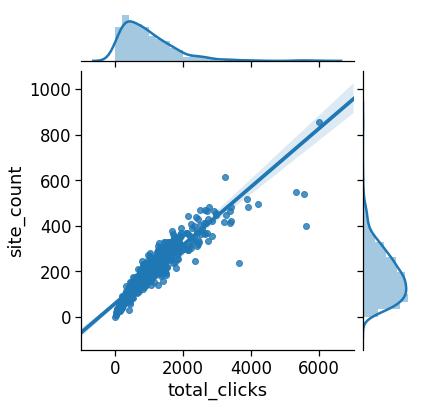

In [8]:
# Plot the correlation between total_clicks and number of sites visited
sns.jointplot(x='total_clicks', y='site_count', data=df, kind='reg')
# Save the figure to path with a "tight" bounding box around the figure
plt.savefig(os.path.join(OUT_PATH, 'jointplot_final_results.pdf'),
            bbox_inches='tight')

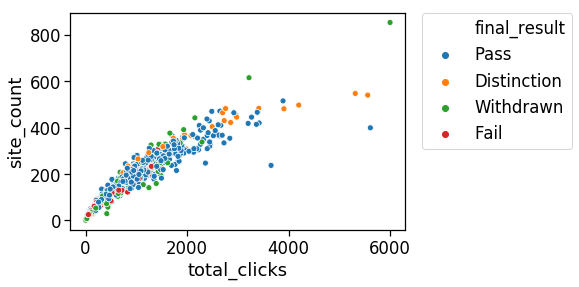

In [9]:
# Plot the final result as well
sns.scatterplot(x='total_clicks', y='site_count', hue='final_result', data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


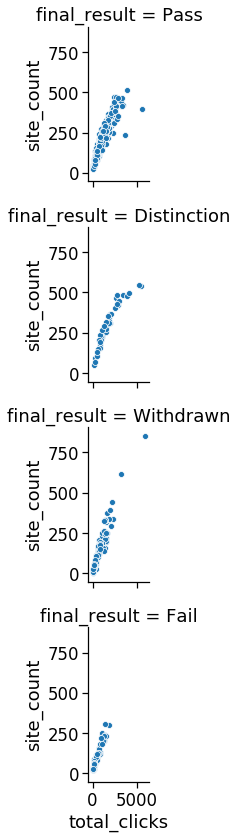

In [10]:
# Individual plot for each final result
g = sns.FacetGrid(df, row='final_result')
_ = g.map(sns.scatterplot, 'total_clicks', 'site_count')


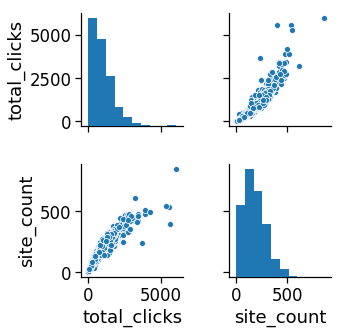

In [11]:
# Are the features correlated (TODO how to check)
sns.pairplot(df)


#### What does other features look like?
- What features should be selected?
- How to create a data set that looks at asset use as well?
- Check correlation between features
- Check the variance of the features
  